In [ ]:
# structure of dataset IEMOCAP
'''
IEMOCAP_full_release/
|------ Documentation/
|      |----- corpus.dic
|      |----- Five_face_markers2.png
|      |----- HumaineInfo.txt
|      |----- phonemes.txt
|      |----- timeinfo.txt
|------ Session1/
|      |---- dialog/
|      |     |---- avi
|      |     |---- EmoEvaluation
|      |     |---- lab
|      |     |---- MOCAP_hand
|      |     |---- MOCAP_head
|      |     |---- MOCAP_rotated
|      |     |---- transcriptions
|      |     |---- wav
|      |---- sentences/
|------ Session2/
|------ Session3/
|------ Session4/
|------ Session5/
|------ README_backup.txt
|------ README.txt
'''

In [1]:
import os, shutil
import torchaudio
from io import StringIO
import torch
import sndhdr
import soundfile
import csv,glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/var/folders/qq/pfl0n6y54hn4zsl5b016ysm00000gn/T/ipykernel_3015/1278056665.py:5: DeprecationWarning: 'sndhdr' is deprecated and slated for removal in Python 3.13
  import sndhdr


# 1. Extract feature

In [2]:
os.getcwd()
os.chdir('/Users/baoxuyennguyenle/Desktop/SER') # Replace by your direction to datast IEMOCAP

In [3]:
# Read link
def read_link_wav(type = ('sentences', 'dialog'), sessions = [1,2,3,4,5]):
    link = os.path.join('IEMOCAP_full_release', 'Session'+str(sessions), type, 'wav')
    links = {}
    if type == 'dialog':
        return
    for dialog in os.listdir(link):
        list_sentence = []
        for sentence in os.listdir(os.path.join(link,dialog)):
            sentence_link = os.path.join(link, dialog, sentence)
            list_sentence.append(sentence_link)
        links[dialog] = list_sentence
    return links

In [4]:

#.wav to .pt
def read_and_save_mfcc(types = ('dialog','sentences')):
    for session in range(1,6):
        links = read_link_wav(types, session)
        root = os.path.join('IEMOCAP_full_release','Session'+str(session),types)
        if os.path.exists(os.path.join(root,'mfcc')):
            shutil.rmtree(os.path.join(root,'mfcc'))
        os.makedirs(os.path.join(root,'mfcc'))
        for dia in links.keys():
            if os.path.exists(os.path.join(root,'mfcc',dia)):
                shutil.rmtree(os.path.join(root,'mfcc',dia))
            os.makedirs(os.path.join(root,'mfcc',dia))
            for sen in links[dia]:
                try:
                    if sndhdr.what(sen).filetype == 'wav':
                        waveform, sample_rate = torchaudio.load(sen)
                        transform = torchaudio.transforms.MFCC(sample_rate=sample_rate)
                        mfcc = transform(waveform)
                        output_file = os.path.join(root,'mfcc',dia,os.path.basename(sen)[:-4]+'.pt')
                        torch.save(mfcc,output_file)
                except:
                    pass

In [5]:
# extract feature .wav to .pt
read_and_save_mfcc('sentences')

/Users/baoxuyennguyenle/anaconda3/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/Users/baoxuyennguyenle/anaconda3/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/Users/baoxuyennguyenle/anaconda3/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/Users/baoxuyennguyenle/anaconda3/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filte

# 2. Create label + write to file "csv"

In [6]:

def get_shape(file):
    mfcc = torch.load(file)
    return list(mfcc.shape)
def update_sample(categories,session,words):
    if len(words)==4:
        path_file = os.path.join('IEMOCAP_full_release','Session'+str(session),'sentences','mfcc',words[1][:-5],words[1]+'.pt')
        if os.path.exists(path_file):
            shape = get_shape(path_file)
            with open('processed_label_data.csv',mode = 'a',newline = '') as f:
                write = csv.writer(f)
                if (words[2]) in categories['positive']:
                    write.writerow([words[1],words[2],1,0,0,shape,shape[2],path_file])
                elif (words[2]) in categories['neutral']:
                    write.writerow([words[1],words[2],0,1,0,shape,shape[2],path_file])
                elif (words[2]) in categories['negative']:
                    write.writerow([words[1],words[2],0,0,1,shape,shape[2],path_file])
                else:
                    write.writerow([words[1],words[2],0,0,0,shape,shape[2],path_file])
def create_label_file():
    categories = {'positive': ['exc', 'hap'],
                'neutral': ['neu'],
                'negative': ['fea','ang','sad','dis','fru']}
    header = ['sessionID','labels','positive','neutral','negative','dims','time_shape','path']
    with open('processed_label_data.csv',mode='w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
    for session in range(1,6):
        root = os.path.join('IEMOCAP_full_release','Session'+str(session),'dialog','EmoEvaluation','*')
        files = glob.glob(root)
        for file in files:
            if file[-3:] =='txt': 
                with open(file, 'r') as lines:
                    for line in lines:
                        words = line.split("\t")
                        update_sample(categories,session,words)

In [7]:
create_label_file()

# 3. EDA

In [8]:
data = pd.read_csv('processed_label_data.csv')
data.head(10)

sessionID labels  positive  neutral  negative          dims  \
0  Ses01M_impro01_F000    ang         0        0         1  [1, 40, 136]   
1  Ses01M_impro01_F001    ang         0        0         1  [1, 40, 165]   
2  Ses01M_impro01_F002    xxx         0        0         0  [1, 40, 302]   
3  Ses01M_impro01_F003    xxx         0        0         0  [1, 40, 316]   
4  Ses01M_impro01_F004    fru         0        0         1  [1, 40, 244]   
5  Ses01M_impro01_F005    xxx         0        0         0  [1, 40, 205]   
6  Ses01M_impro01_F006    xxx         0        0         0  [1, 40, 196]   
7  Ses01M_impro01_F007    ang         0        0         1  [1, 40, 274]   
8  Ses01M_impro01_F008    ang         0        0         1  [1, 40, 299]   
9  Ses01M_impro01_F009    xxx         0        0         0  [1, 40, 223]   

   time_shape                                               path  
0         136  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
1         165  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
2         302  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
3         316  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
4         244  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
5         205  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
6         196  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
7         274  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
8         299  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
9         223  IEMOCAP_full_release/Session1/sentences/mfcc/S...

In [9]:
data.count()

sessionID     10039
labels        10039
positive      10039
neutral       10039
negative      10039
dims          10039
time_shape    10039
path          10039
dtype: int64

In [10]:
data['labels'].value_counts()

labels
xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: count, dtype: int64

### 3.1. Choose labels

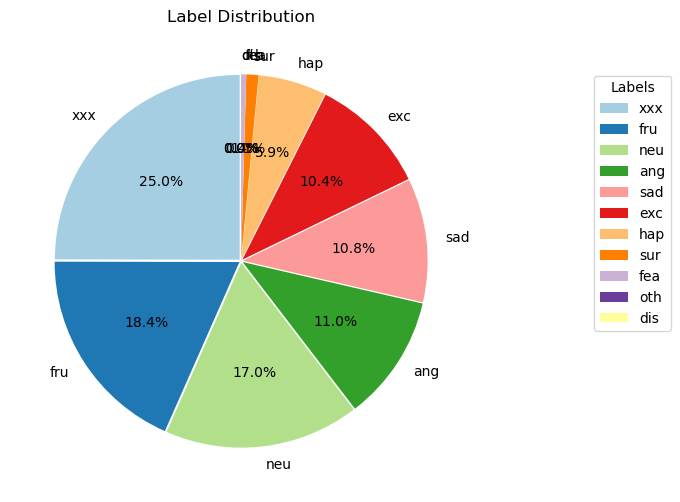

In [11]:
percentage = data['labels'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
explode = [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
plt.pie(percentage, labels=percentage.index, explode=explode, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Label Distribution')
plt.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1.25, 0, 0.5, 1.25))
plt.show()

In [12]:
# remove unneccessary labels
data = data[~data['labels'].isin(['xxx', 'oth', 'dis', 'fea','sur'])].reset_index(drop = True)
data.to_csv('processed_label_data.csv')

In [13]:
data.head(10)

sessionID labels  positive  neutral  negative          dims  \
0  Ses01M_impro01_F000    ang         0        0         1  [1, 40, 136]   
1  Ses01M_impro01_F001    ang         0        0         1  [1, 40, 165]   
2  Ses01M_impro01_F004    fru         0        0         1  [1, 40, 244]   
3  Ses01M_impro01_F007    ang         0        0         1  [1, 40, 274]   
4  Ses01M_impro01_F008    ang         0        0         1  [1, 40, 299]   
5  Ses01M_impro01_F010    fru         0        0         1  [1, 40, 162]   
6  Ses01M_impro01_F011    ang         0        0         1  [1, 40, 173]   
7  Ses01M_impro01_F012    ang         0        0         1  [1, 40, 155]   
8  Ses01M_impro01_F015    fru         0        0         1  [1, 40, 481]   
9  Ses01M_impro01_F019    ang         0        0         1  [1, 40, 289]   

   time_shape                                               path  
0         136  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
1         165  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
2         244  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
3         274  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
4         299  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
5         162  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
6         173  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
7         155  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
8         481  IEMOCAP_full_release/Session1/sentences/mfcc/S...  
9         289  IEMOCAP_full_release/Session1/sentences/mfcc/S...

In [14]:
data.count()

sessionID     7380
labels        7380
positive      7380
neutral       7380
negative      7380
dims          7380
time_shape    7380
path          7380
dtype: int64

In [15]:
data['labels'].value_counts()

labels
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
Name: count, dtype: int64

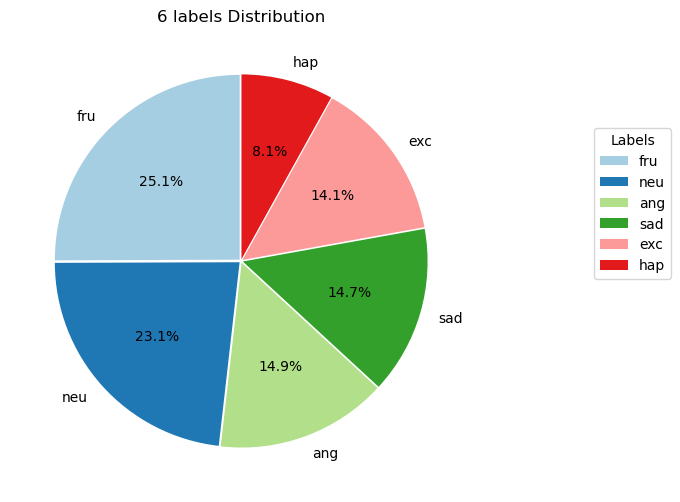

In [16]:
percentage = data['labels'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
explode = [0.01,0.01,0.01,0.01,0.01,0.01]
plt.pie(percentage, labels=percentage.index, explode=explode, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('6 labels Distribution')
plt.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1.25, 0, 0.5, 1.25))
plt.show()

In [17]:
num_pos = sum(data['positive'] == 1)
num_neg = sum(data['negative'] == 1)
num_neu = sum(data['neutral'] == 1)
print('Number of positive label: ', num_pos)
print('Number of negative label: ', num_neg)
print('Number of neutral label: ', num_neu)

Number of positive label:  1636
Number of negative label:  4036
Number of neutral label:  1708


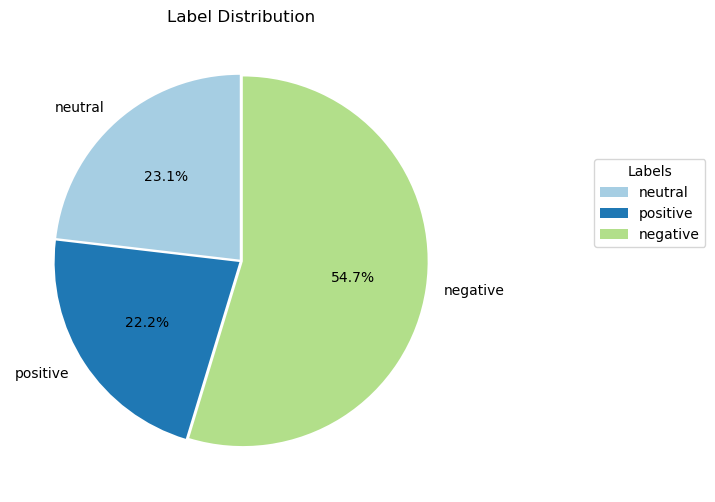

In [18]:
three_labels = [num_neu, num_pos, num_neg]
#percentage = (three_labels/3) * 100
plt.figure(figsize=(8, 6))
explode = [0.01,0.01,0.01]
plt.pie(three_labels, labels=['neutral', 'positive', 'negative'], explode=explode, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Label Distribution')
plt.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1.25, 0, 0.5, 1.25))
plt.show()

- Remove specific labels ('xxx' and 'oth') and labels with too few occurrences ('dis', 'fea', 'sur')
- After remove we have 6 labels and choose ('exc', 'hap') as positive
                                            ('fea','ang','sad','dis','fru') as negative
                                            ('neu') as neutral
- Number of samples decreases from 10039 to 7380 samples with 
    + Number of positive label:  1636
    + Number of negative label:  4036
    + Number of neutral label:  1708

### 3.2 Resize timeshape

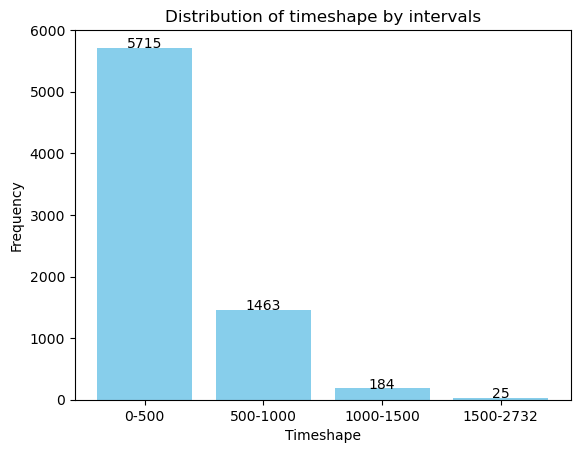

In [19]:
time = data['time_shape']
ranges = [(0,500), (500,1000), (1000, 1500), (1500, max(time))]

# Create a list to store counts in each range
counts = [0] * 4

for num in time:
    for i, (start, end) in enumerate(ranges):
        if start <= int(num) <= end:
            counts[i] += 1

plt.bar([f"{r[0]}-{r[1]}" for r in ranges], counts, color='skyblue')

for i, (start, end) in enumerate(ranges):
    plt.text(i,counts[i] + 1, str(counts[i]), ha = "center")

plt.xlabel("Timeshape")   
plt.ylabel('Frequency')
plt.title('Distribution of timeshape by intervals')
plt.show()

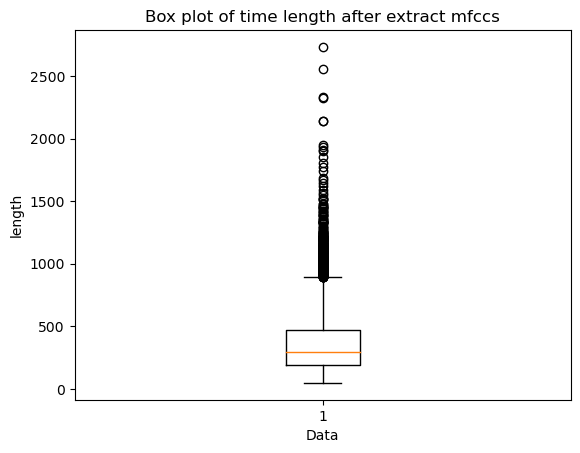

In [20]:
fig, ax = plt.subplots()
ax.boxplot(time)

ax.set_title('Box plot of time length after extract mfccs')
ax.set_xlabel('Data')
ax.set_ylabel('length')
plt.show() 

In [21]:
def reform_file_data():
    df = pd.read_csv('processed_label_data.csv')
    df['dims'] = df['dims'].apply(lambda x: [int(i) for i in x.strip('[]').split(',')])
    if str(df['time_shape'].dtype) == 'object':
        df['time_shape'] = df['time_shape'].apply(lambda x: x.strip('[]').split(','))
    df.to_csv('processed_label_data.csv', index=False)
    return df

In [22]:
#check for mono file audio or not
def check_mono():

    for session in range(1,6):
        root = os.path.join('IEMOCAP_full_release','Session'+str(session),'sentences','mfcc')
        for dialog in os.listdir(root):
            for sentence in os.listdir(os.path.join(root,dialog)):
                sample = torch.load(os.path.join(root,dialog,sentence))
                if sample.shape[0]!=1:
                    return False
    return True

In [23]:
#convert to size[1,40,900]
def normalize_shape(time_shape):
    df = reform_file_data()
    for sample in range(len(data)):
        tmp_sample = torch.load(df.path[sample])
        # if len(tmp_sample.shape) == 3:
        #     tmp_sample = tmp_sample.resize(40,tmp_sample.shape[2])
        if tmp_sample.shape[2] == time_shape:
            continue
        if tmp_sample.shape[2] >time_shape:
            tmp_sample = tmp_sample[:,:,:time_shape]
        while tmp_sample.shape[2]<time_shape:
            last_dims = time_shape - tmp_sample.shape[2]
            if last_dims > tmp_sample.shape[2]:
                tmp_sample = torch.cat((tmp_sample,tmp_sample),dim=2)
            else:
                tmp_sample = torch.cat((tmp_sample,tmp_sample[:,:,:last_dims]),dim=2)
        tmp_sample = torch.cat((tmp_sample,tmp_sample), dim = 0)
        torch.save(tmp_sample,df.path[sample])
        df['time_shape'][sample] = time_shape
        df['dims'][sample] = [40,time_shape]
    df.to_csv('processed_shape_data.csv')

In [24]:
def check_shape(time_shape):
    df = reform_file_data()
    for sample in range(len(df)):
        tmp_sample = torch.load(df.path[sample])
        if list(tmp_sample.shape) != [40,time_shape]:
            print(list(tmp_sample.shape))
            return False
    return True

In [25]:
print('Mono before nomalize: ',check_mono())
normalize_shape(900)
print('Mono after nomalize: ',check_mono())
check_shape(900)

Mono before nomalize:  True


/var/folders/qq/pfl0n6y54hn4zsl5b016ysm00000gn/T/ipykernel_3015/979906686.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_shape'][sample] = time_shape
/var/folders/qq/pfl0n6y54hn4zsl5b016ysm00000gn/T/ipykernel_3015/979906686.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dims'][sample] = [40,time_shape]
/var/folders/qq/pfl0n6y54hn4zsl5b016ysm00000gn/T/ipykernel_3015/979906686.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Mono after nomalize:  False
[2, 40, 900]


/var/folders/qq/pfl0n6y54hn4zsl5b016ysm00000gn/T/ipykernel_3015/979906686.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_shape'][sample] = time_shape
/var/folders/qq/pfl0n6y54hn4zsl5b016ysm00000gn/T/ipykernel_3015/979906686.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dims'][sample] = [40,time_shape]
/var/folders/qq/pfl0n6y54hn4zsl5b016ysm00000gn/T/ipykernel_3015/979906686.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

False

In [26]:
def draw_waveform(data):
    label_counts = {'ang': 0, 'fru': 0, 'neu': 0, 'sad': 0, 'exc': 0, 'hap': 0}
    emotions = ['ang', 'fru', 'neu', 'sad', 'exc', 'hap']
    row_colors = ['b', 'g', 'r', 'c', 'm', 'y']  # You can customize this list with your desired colors

    for i, label in enumerate(data['labels']):
        if label in emotions and label_counts[label] < 5:
            label_counts[label] += 1

    num_rows = len(emotions)
    num_cols = 5

    # Create subplots with multiple rows and 5 columns, sharing axes
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 4), sharey=True)

    for i, emotion in enumerate(emotions):
        row_color = row_colors[i]
        for j in range(num_cols):
            ax = axes[i, j]
            index = i * num_cols + j
            base, _ = os.path.splitext(data['path'][index])
            file_path = base + '.wav'
            file_path = file_path.replace('mfcc', 'wav')
            waveform, _ = torchaudio.load(file_path)
            ax.plot(waveform.t().numpy(), label=f'Waveform {emotion})', color=row_color)
            ax.set_title(f'{emotion} - {j+1}')
            ax.set_ylabel('Amplitude')

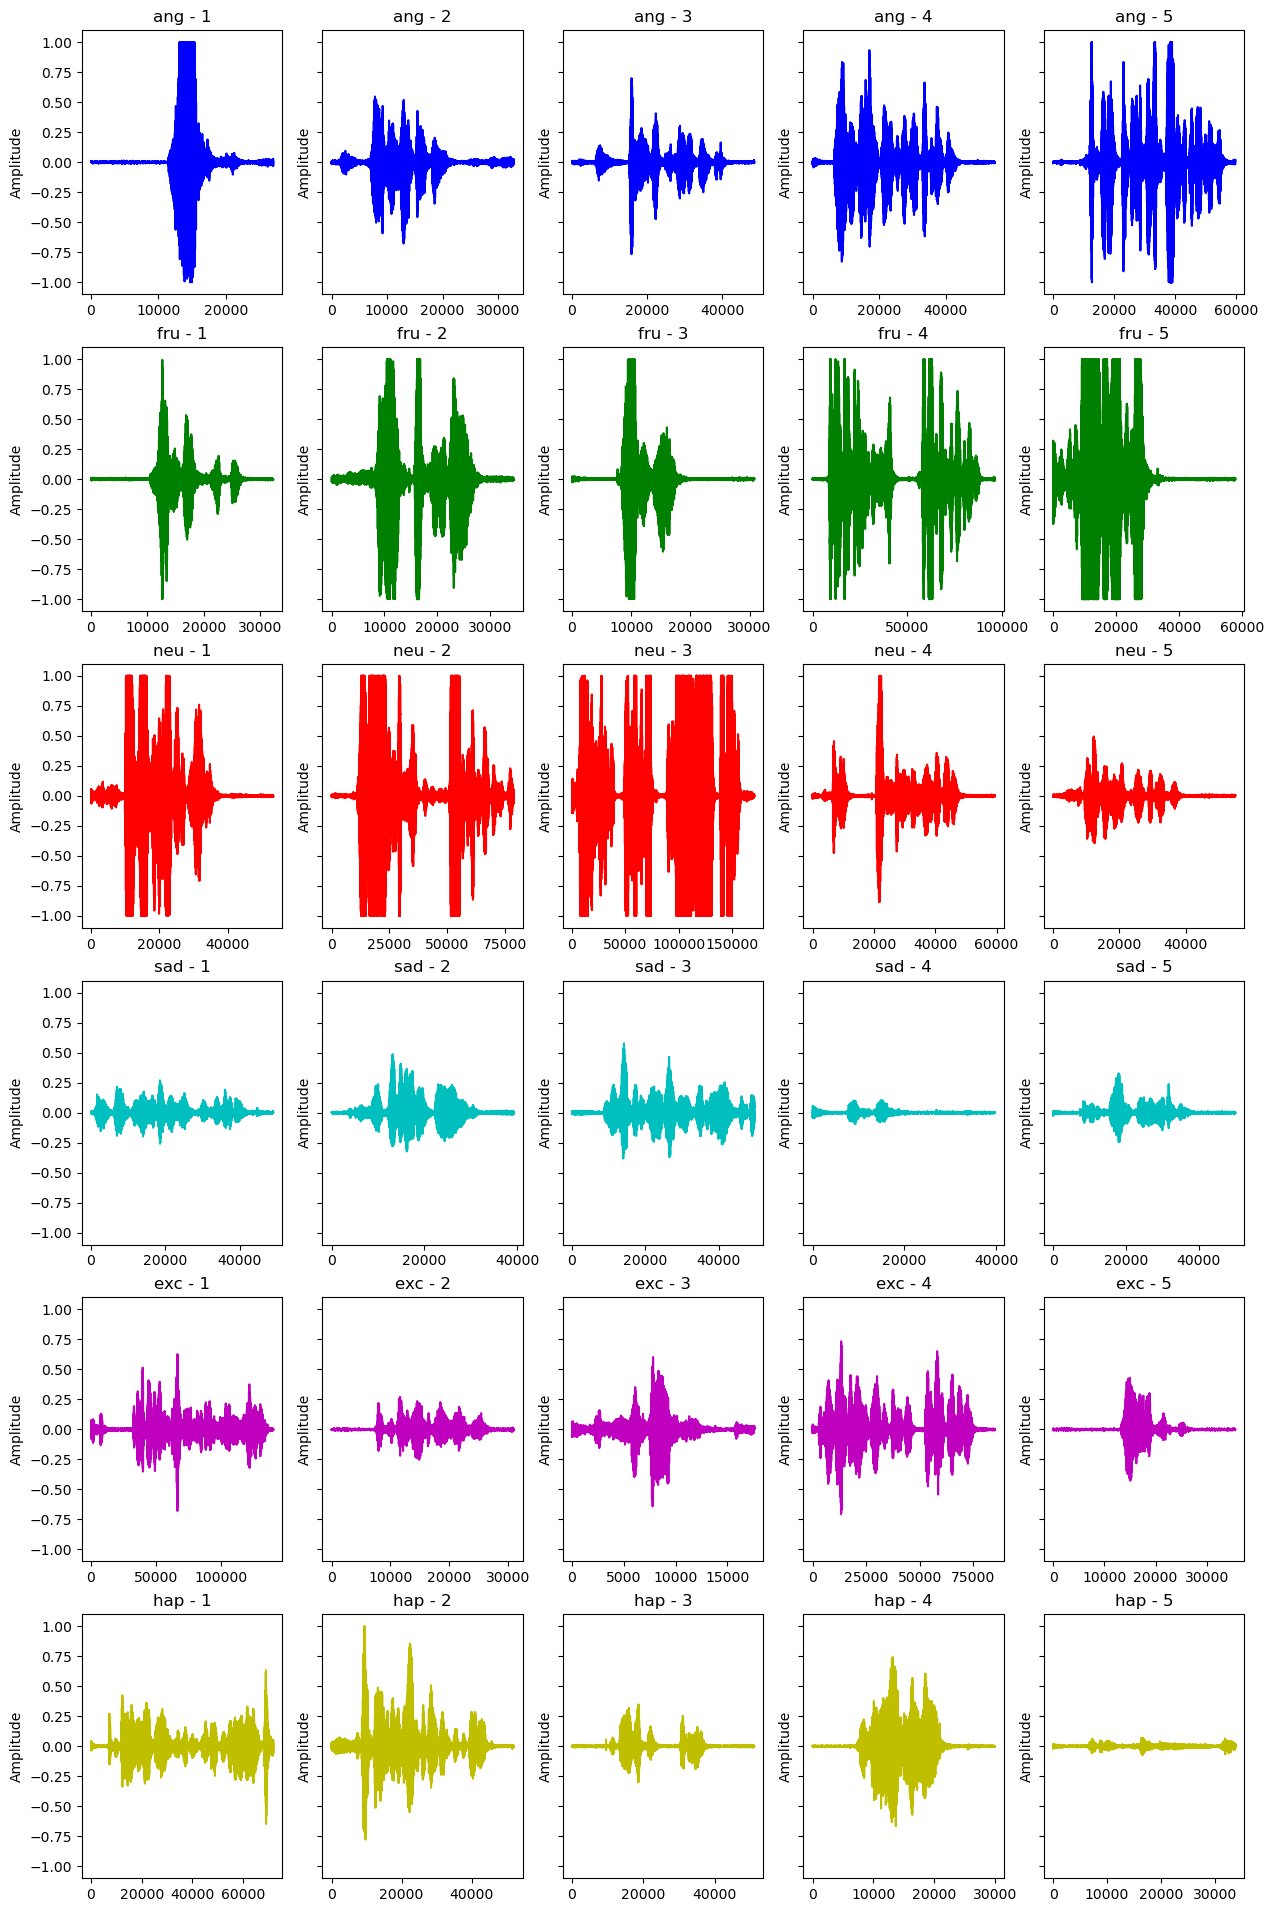

In [27]:
draw_waveform(data)

### 3.3 Balance dataset

In [31]:
import torchaudio.functional as F
import random

In [28]:
def background_noise(path,output_file):
    waveform, sample_rate = torchaudio.load(path, channels_first=False)
    speech, _ = torchaudio.load(path)
    noise, _ = torchaudio.load(path)
    noise = noise[:, : speech.shape[1]]

    snr_dbs = torch.tensor([30, 20, 3])
    noisy_speeches = F.add_noise(speech, noise, snr_dbs)


    snr_db, noisy_speech = snr_dbs[0], noisy_speeches[0:1]
    # print(noisy_speech)
    # plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
    # plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
    # torch.save(noisy_speech,'test.pt')
    #r= Audio(noisy_speech, rate=sample_rate)
    
    transform = torchaudio.transforms.MFCC(sample_rate=sample_rate)
    mfccs = transform(noisy_speech)
    #features = extract_mfcc_features(background_noise_1, sample_rate)
    torch.save(mfccs,output_file)

In [29]:
def read_and_save_backgound_noise():
    root = os.path.join(link_to_data(),'IEMOCAP_full_release\Background')
    df = pd.read_csv('processed_label_data.csv')
    df_shape = pd.read_csv('processed_shape_data.csv')
    df_neu = df.loc[df.neutral == 1]
    df_neu = df_neu.sample(frac=1).reset_index()
    for index in range(len(df_neu)):
        file = os.path.join(root,'neutral','sample'+str(index)+'.pt')
        path = df_neu.path[index][:-3].replace('mfcc','wav') + '.wav'
        background_noise(path, file)
        new_row = {'sessionID':'Background'+str(index),'labels':'neu_','positive':0,'neutral':1,'negative':0,'path':file}
        df_shape = pd.concat([df_shape, pd.DataFrame([new_row])], ignore_index=True)
    df_pos = df.loc[df.positive == 1]
    df_pos = df_pos.sample(frac=1).reset_index()
    for index in range(len(df_pos)):
        file = os.path.join(root,'positive','sample'+str(index)+'.pt')
        path = df_pos.path[index][:-3].replace('mfcc','wav') + '.wav'
        background_noise(path, file)
        new_row = {'sessionID':'Background'+str(index),'labels':'pos_','positive':1,'neutral':0,'negative':0,'path':file}
        df_shape = pd.concat([df_shape, pd.DataFrame([new_row])], ignore_index=True)
    df_ne = df.loc[df.negative == 1]
    df_ne = df_ne.sample(frac=1).reset_index()
    for index in range(2000):
        random_ = random.randint(0,df_ne.shape[0]-1)
        path = df_ne.path[index][:-3].replace('mfcc','wav') + '.wav'
        background_noise(path, df_ne.path[random_])
    df_shape.to_csv('processed_shape_data___.csv',index = False)

In [ ]:
def normalize_shape(path, time_shape):
    tmp_sample = torch.load(path)
    # if len(tmp_sample.shape) == 3:
    #     tmp_sample = tmp_sample.resize(40,tmp_sample.shape[2])
    if tmp_sample.shape[-1] >time_shape:
        tmp_sample = tmp_sample[:,:,:time_shape]
    while tmp_sample.shape[-1]<time_shape:
        last_dims = time_shape - tmp_sample.shape[-1]
        if last_dims > tmp_sample.shape[-1]:
            tmp_sample = torch.cat((tmp_sample,tmp_sample),dim=2)
        else:
            tmp_sample = torch.cat((tmp_sample,tmp_sample[:,:,:last_dims]),dim=2)
    tmp_sample = torch.cat((tmp_sample,tmp_sample), dim = 0)
    torch.save(tmp_sample,path)

In [ ]:
### add sample for more 1000_ne, 1636_pos, 1708_neu
def balance_data_timemask():    
    root = os.path.join(link_to_data(),'IEMOCAP_full_release\Timemask')
    df = pd.read_csv('processed_label_data.csv')
    df_neu = df.loc[df.neutral == 1]
    df_neu = df_neu.sample(frac=1).reset_index()
    for index in range(len(df_neu)):
        file = os.path.join(root,'neutral','sample'+str(index)+'.pt')
        split_augmentation(df_neu.path[index], file)
        new_row = {'sessionID':'Session0'+str(index),'labels':'neu_','positive':0,'neutral':1,'negative':0,'path':file}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df_pos = df.loc[df.positive == 1]
    df_pos = df_pos.sample(frac=1).reset_index()
    for index in range(len(df_pos)):
        file = os.path.join(root,'positive','sample'+str(index)+'.pt')
        split_augmentation(df_pos.path[index], file)
        new_row = {'sessionID':'Session0'+str(index),'labels':'pos_','positive':1,'neutral':0,'negative':0,'path':file}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df_ne = df.loc[df.negative == 1]
    df_ne = df_ne.sample(frac=1).reset_index()
    for index in range(1000):
        random_ = random.randint(0,df_ne.shape[0]-1)
        file = os.path.join(root,'negative','sample'+str(index)+'.pt')
        split_augmentation(df_ne.path[random_], file)
        new_row = {'sessionID':'Session0'+str(index),'labels':'pos_','positive':0,'neutral':0,'negative':1,'path':file}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_csv('processed_shape_data___.csv',index = False)

In [34]:
noise_data = pd.read_csv('processed_shape_data.csv')
noise_data.head(10)

sessionID labels  positive  neutral  negative          dims  \
0  Ses01F_impro01_F000    neu         0        1         0  [1, 40, 156]   
1  Ses01F_impro01_F001    neu         0        1         0  [1, 40, 111]   
2  Ses01F_impro01_F002    neu         0        1         0  [1, 40, 251]   
3  Ses01F_impro01_F005    neu         0        1         0  [1, 40, 323]   
4  Ses01F_impro01_F006    fru         0        0         1  [1, 40, 371]   
5  Ses01F_impro01_F007    fru         0        0         1  [1, 40, 449]   
6  Ses01F_impro01_F008    fru         0        0         1  [1, 40, 214]   
7  Ses01F_impro01_F009    fru         0        0         1  [1, 40, 329]   
8  Ses01F_impro01_F011    fru         0        0         1  [1, 40, 785]   
9  Ses01F_impro01_F012    ang         0        0         1  [1, 40, 221]   

  time_shape                                               path  
0  [40, 156]  c:\Users\hoang\Pojects\audio2emotion\IEMOCAP_f...  
1  [40, 111]  c:\Users\hoang\Pojects\audio2emotion\IEMOCAP_f...  
2  [40, 251]  c:\Users\hoang\Pojects\audio2emotion\IEMOCAP_f...  
3  [40, 323]  c:\Users\hoang\Pojects\audio2emotion\IEMOCAP_f...  
4  [40, 371]  c:\Users\hoang\Pojects\audio2emotion\IEMOCAP_f...  
5  [40, 449]  c:\Users\hoang\Pojects\audio2emotion\IEMOCAP_f...  
6  [40, 214]  c:\Users\hoang\Pojects\audio2emotion\IEMOCAP_f...  
7  [40, 329]  c:\Users\hoang\Pojects\audio2emotion\IEMOCAP_f...  
8  [40, 785]  c:\Users\hoang\Pojects\audio2emotion\IEMOCAP_f...  
9  [40, 221]  c:\Users\hoang\Pojects\audio2emotion\IEMOCAP_f...

In [35]:
noise_data.count()

sessionID     15110
labels        15110
positive      15110
neutral       15110
negative      15110
dims           7422
time_shape     7422
path          15110
dtype: int64

In [36]:
noise_data['labels'].value_counts()

labels
pos_    4272
neu_    3416
fru     1849
neu     1708
ang     1103
sad     1084
exc     1041
hap      595
fea       40
dis        2
Name: count, dtype: int64

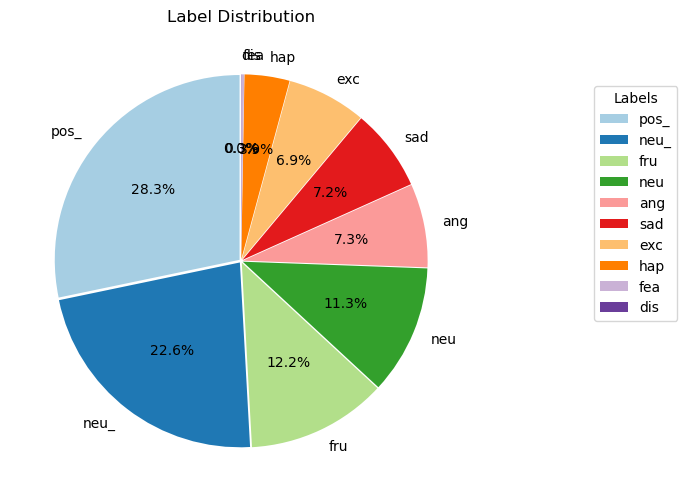

In [47]:
percentage = noise_data['labels'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
explode = [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
plt.pie(percentage, labels=percentage.index, explode = explode, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Label Distribution')
plt.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1.25, 0, 0.5, 1.25))
plt.show()

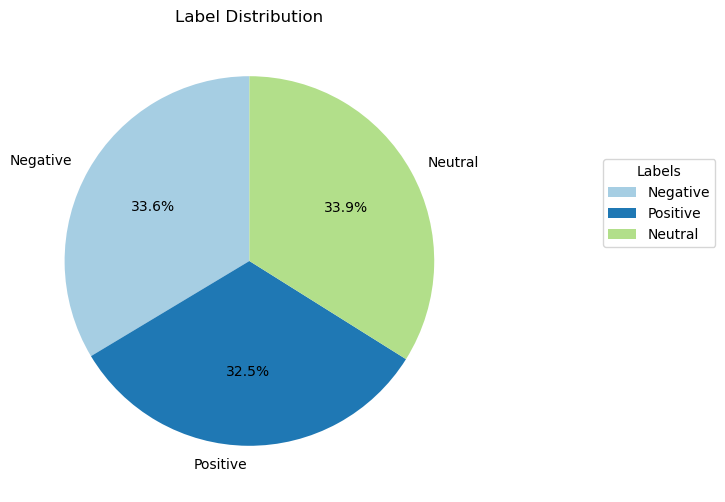

In [46]:
num_pos = sum(noise_data['positive'] == 1)
num_neg = sum(noise_data['negative'] == 1)
num_neu = sum(noise_data['neutral'] == 1)

num_labels = [num_neg, num_pos, num_neu]
plt.figure(figsize=(8, 6))
#explode = [0.01,0.01,0.01]
plt.pie(num_labels, labels=['Negative', 'Positive', 'Neutral'],  autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Label Distribution')
plt.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1.25, 0, 0.5, 1.25))
plt.show()

# 4. Real dataset

In [59]:
def count_files(path, languages = ['English', 'Vietnamese'], emos = ['negative', 'neutral', 'positive']):

    list_eng = []
    list_viet = []
    for language in languages:
        
        total_emotions = 0
        for emo in emos:
            full_path = os.path.join(path, language, 'raw', emo)
            list_files = os.listdir(full_path)
            total_emotions += len(list_files)
            if language == 'English':
                list_eng.append(len(list_files))
            else:
                list_viet.append(len(list_files))
            print(f'Number of {language} {emo} samples : {len(list_files)}')  
           
        print(f'Total number of {language}: {total_emotions}')
        
    return list_eng, list_viet

In [61]:
list_eng, list_viet = count_files('./Real_data')

Number of English negative samples : 114
Number of English neutral samples : 109
Number of English positive samples : 107
Total number of English: 330
Number of Vietnamese negative samples : 89
Number of Vietnamese neutral samples : 88
Number of Vietnamese positive samples : 88
Total number of Vietnamese: 265


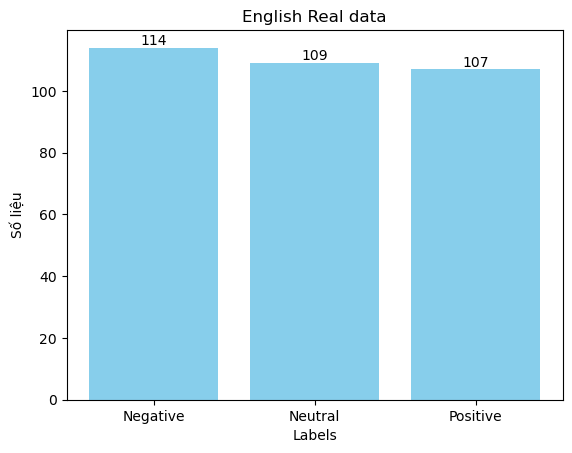

In [67]:
bars = plt.bar(['Negative', 'Neutral', 'Positive'],list_eng, color='skyblue')

# Hiển thị số lên trên mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.title('English Real data')
plt.xlabel('Labels')
plt.ylabel('Số liệu')
plt.show()

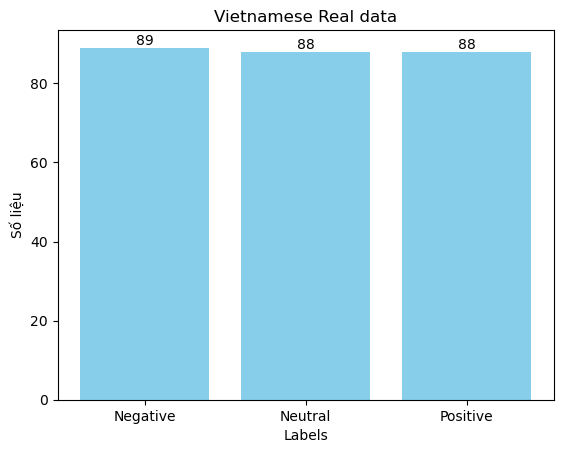

In [69]:
bars = plt.bar(['Negative', 'Neutral', 'Positive'],list_viet, color='skyblue')

# Hiển thị số lên trên mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.title('Vietnamese Real data')
plt.xlabel('Labels')
plt.ylabel('Số liệu')
plt.show()